# Imports & setup

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import zipfile
import glob
import os
from google.colab import drive
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import tensorflow as tf
from pathlib import Path
import glob
import numpy as np
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
path_model = '/content/gdrive/My Drive/Learning_ML/ITC Program/Projects/final_project/adidas/02-model'
path_data =  '/content/gdrive/My Drive/Learning_ML/ITC Program/Projects/final_project/adidas/01-data'
os.listdir(path_model) # test

['.ipynb_checkpoints',
 'weights',
 'logs',
 'model',
 'LeNet-Model',
 'tf image classification.ipynb',
 'tf image classification - Dor.ipynb',
 'Daniel Research Log.gdoc',
 'GAN',
 'MobileNet-19cities-ACC90.h5',
 'inceptionsV3_19cities.h5',
 'inceptionsV3_19cities_at.h5']

In [ ]:
# colab output:
output_folder_path = '.'
output_folder_path = Path(output_folder_path)

# Load Data


In [ ]:
# get list of links from aws
map_links = pd.read_csv(
    'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/mapillary_links.csv'
    ,header=None).iloc[:,0].to_list()

In [ ]:
def download_url(url, save_path=False, chunk_size=128):
    "downloads zip files to the folder that the notebook / python file is saved"
    if not save_path:
        save_path = url.split('/')[-1]

    with requests.get(url, stream=True) as r:
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)
    print(f"file {save_path} succesfuly downloaded")

    
def unzip_to_structure(zipfile_path, output_root_folder):
    """Unzips files to specified output root folder with structure: 
        <output_root_folder> / <set_type> / <city> / <img_key>.jpg"""
    output_root_folder = Path(output_root_folder)
    file_parts = str(Path(zipfile_path).stem).split('_')
    city = file_parts[0]
    set_type = file_parts[1]
    for s in ['train','test','val']:   
      with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
        if set_type == s:
          zip_ref.extractall(output_root_folder / s )
    print(f"images from '{zipfile_path}' succesfuly unziped to '{output_root_folder / set_type / city}'")


def get_images(cities,output_path=output_folder_path,download_test=False):
  """Gets all images for defined cities
  param:: cities, array of cities
  param:: output_path """
  linkz = []
  if not download_test:
    links = [l for l in map_links if 'test' not in l]
  else:
    links = map_links
  for city in cities:
    for link in links:
      if city in link:
        linkz.append(link) 
  # download files to current directory
  for link in linkz:
      download_url(link)
  # unzip images to destination with format: 
  # <output_root_folder> / <set_type> / <city> / <img_key>.jpg
  for link in linkz:
      filename = Path(link).name
      unzip_to_structure(filename,output_path)  

In [ ]:
# Get data to current working dir (for changing dir got to top of the notebook):

# Available cities:
my_cities = ['saopaulo','moscow','paris','manila','ottawa','austin','bangkok',
  'sf','phoenix','melbourne','tokyo','goa','toronto','berlin', 'budapest',
  'cph','helsinki','boston','amsterdam']

# City selection:
# My_cities = ['saopaulo','paris','goa']

# My_cities = ['bangkok','saopaulo']

# Download images from aws:
get_images(my_cities,download_test=True) 
!rm *.zip

file saopaulo_train.zip succesfuly downloaded
file saopaulo_val.zip succesfuly downloaded
file saopaulo_test.zip succesfuly downloaded
file moscow_train.zip succesfuly downloaded
file moscow_val.zip succesfuly downloaded
file moscow_test.zip succesfuly downloaded
file paris_train.zip succesfuly downloaded
file paris_val.zip succesfuly downloaded
file paris_test.zip succesfuly downloaded
file manila_train.zip succesfuly downloaded
file manila_val.zip succesfuly downloaded
file manila_test.zip succesfuly downloaded
file ottawa_train.zip succesfuly downloaded
file ottawa_val.zip succesfuly downloaded
file ottawa_test.zip succesfuly downloaded
file austin_train.zip succesfuly downloaded
file austin_val.zip succesfuly downloaded
file austin_test.zip succesfuly downloaded
file bangkok_train.zip succesfuly downloaded
file bangkok_val.zip succesfuly downloaded
file bangkok_test.zip succesfuly downloaded
file sf_train.zip succesfuly downloaded
file sf_val.zip succesfuly downloaded
file sf_test.

# Image Preprocessing

# Convolutional autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.


Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

## Functions

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import math
from PIL import Image  
import PIL  
import gc
gc.collect()
from pathlib import Path
import glob
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
HIGHT=150
WIDTH=150
channels=3

def autoencoder_model():
  # Create the CV for decoding
  input_img = Input(shape=(HIGHT, WIDTH, channels))  # adapt this if using `channels_first` image data format
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  # x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)
  # At this point the representation is (4, 4, 8) i.e. 128-dimensional
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu')(x)
  # x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  # autoencoder.summary()
  return autoencoder, encoded, decoded, input_img

def decode_images_using_existing_model_weights(dataset,weights_path = '/weights/Auto-Encoders.ckpt'):
  """Receives a numpy dataset, returns a decoded (denoised) dataset using 
  the pre-trained auto-encoder weights"""
  autoencoder, _, decoded, _ = autoencoder_model()
  checkpoint_filepath = path_model + weights_path
  autoencoder.load_weights(checkpoint_filepath)
  return autoencoder.predict(dataset)

def encode_images_using_existing_model_weights(dataset,weights_path = '/weights/Auto-Encoders.ckpt'):
  """Receives a numpy dataset, returns an encoded dataset (most relavent pixels)
  using the pre-trained auto-encoder weights"""
  autoencoder, encoded, _, input_img = autoencoder_model()
  checkpoint_filepath = path_model + weights_path
  autoencoder.load_weights(checkpoint_filepath)
  encoded_model = Model(input_img, encoded)
  return encoded_model.predict(dataset)

def autoencoder_shallow_model():
  """Receives a dataset, returns a decoded dataset using the pre-trained 
  pretty-shallow auto-encoder weights"""
  # Create the network
  input_img = Input(shape=(HIGHT, WIDTH, channels))  # adapt this if using `channels_first` image data format
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((1, 1), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)
  # At this point the representation is (7, 7, 32)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  # x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  # autoencoder.summary()

  return autoencoder, encoded, decoded, input_img


def decode_images_using_existing_shallow_model_weights(dataset,weights_path = '/weights/Auto-Encoders-denoiser.ckpt'):
  """Receives a numpy dataset, returns a decoded (denoised) dataset using 
  the pre-trained auto-encoder weights"""
  autoencoder, _, decoded, _ = autoencoder_shallow_model()
  checkpoint_filepath = path_model + weights_path
  autoencoder.load_weights(checkpoint_filepath)
  return autoencoder.predict(dataset)

def encode_images_using_existing_shallow_model_weights(dataset,weights_path = '/weights/Auto-Encoders-denoiser.ckpt'):
  """Receives a numpy dataset, returns an encoded dataset (most relevant pixels)
  using the pre-trained auto-encoder weights"""
  autoencoder, encoded, _, input_img = autoencoder_shallow_model()
  checkpoint_filepath = path_model + weights_path
  autoencoder.load_weights(checkpoint_filepath)
  encoded_model = Model(input_img, encoded)
  return encoded_model.predict(dataset)

def clean_dataset_from_outlier(dataset, decoded_dataset, outlier_threshold=0.98):
  """Receives the original and the autoencoded numpy dataset, return cleaned dataset
  without (default) 1% of images which are least similar to their decoded
  image, and the indices for the outliers."""
  squred_error = np.power(dataset - decoded_dataset, 2)
  channel_ax = 3
  width_ax = 1
  height_ax = 1
  mse = np.mean(np.mean(squred_error,axis=(channel_ax,width_ax)),axis=height_ax)
  mse_anomally_threshold = np.quantile(mse, outlier_threshold)
  outliers_idx = np.where(mse > mse_anomally_threshold)
  inliners_idx = np.where(mse <= mse_anomally_threshold)
  return dataset[inliners_idx], outliers_idx[0], mse

def show_original_and_decoded(original,decoded=None, n=5, show_decoded=True):
  'Show random n images and their decoded images'
  n += 1
  images_index = np.random.choice(len(original),n)
  plt.figure(figsize=(20, 5))
  for i in range(1,n):
      ax = plt.subplot(1, n, i)
      plt.imshow(original[images_index[i]])
      #plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

  if show_decoded:
    plt.figure(figsize=(20, 5))
    for i in range(1,n):
        ax = plt.subplot(1, n, i)
        plt.imshow(decoded[images_index[i]])
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def show_original_and_encoded(original,encoded_imgs, n=5):
  'Show random n images and their encoded images'
  n += 1
  images_index = np.random.choice(len(original), n)
  plt.figure(figsize=(20, 5))
  for i in range(1, n):
      ax = plt.subplot(1, n, i)
      plt.imshow(original[images_index[i]])
      #plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

  for j in [0, 4]:
    print(f'Showing the 4 dimentions of {0 + j}-{4 + j - 1} :')
    plt.figure(figsize=(20, 5))
    for i in range(1, n):
        ax = plt.subplot(1, n, i)
        plt.imshow(encoded_imgs[images_index[i]][:, :, 0 + j: 4 + j])
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def remove_autoencoder_outliers(numpy_dataset, outlier_threshold=0.99):
  'Receivs a numpy dataset, return the cleaned dataset and the indices of outliers'
  decoded_imgs = decode_images_using_existing_model_weights(numpy_dataset)
  cleaned_dataset, outliers_idx, mse_outliers = clean_dataset_from_outlier(numpy_dataset, decoded_imgs,outlier_threshold=0.98)
  return cleaned_dataset, outliers_idx, mse_outliers

def show_n_outliers(dataset, outlier_idx, mse_outliers, n=5):
  n_outlier_idx = np.argsort(mse_outliers)[::-1][:n]
  mse_outliers[n_outlier_idx]

def rule_based_clean_outliers(dataset, remove_blackest=True, remove_darkest=False,
                              remove_brightest=False, outlier_threshold=0.98):
  """Gets the numpy dataset and which outliers to remove,
     Returns the cleaned dataset and the indices of the blackest, darkest,
     and brightest photos"""
  sums_all_pixels = np.sum(dataset[:,:,:,:],axis=(1,2,3))
  blackest_idx = np.argsort(np.count_nonzero(dataset[:,:,:,:],axis=(1,2,3)))
  darkest_idx = np.argsort(sums_all_pixels)
  brightest_idx = np.argsort(sums_all_pixels)[::-1]
  if remove_blackest+remove_darkest+remove_brightest==0:
    print("You chose not to remove anything, I'm returning the original dataset outlier indices:")
    return dataset, blackest_idx, darkest_idx, brightest_idx
  
  cleaned_dataset = dataset
  remove_in_each_category = (1-outlier_threshold)/(remove_blackest+remove_darkest+remove_brightest)
  if remove_blackest:
    idx_to_preserve = math.ceil(len(blackest_idx)*remove_in_each_category)
    cleaned_dataset = dataset[blackest_idx[idx_to_preserve:]]
  if remove_darkest:
    idx_to_preserve = math.ceil(len(darkest_idx)*(1-outlier_threshold))
    cleaned_dataset = dataset[darkest_idx[idx_to_preserve:]]
  if remove_brightest:
    idx_to_preserve = math.ceil(len(darkest_idx)*(1-outlier_threshold))
    cleaned_dataset = dataset[brightest_idx[idx_to_preserve:]]
  
  return cleaned_dataset, blackest_idx, darkest_idx, brightest_idx

def remove_outliers(numpy_dataset, outlier_threshold=0.98):
  'Receives a numpy dataset, returns the cleaned dataset and the indices of outliers'
  decoded_imgs = decode_images_using_existing_model_weights(numpy_dataset)
  cleaned_dataset, outliers_idx, mse = clean_dataset_from_outlier(numpy_dataset, decoded_imgs,outlier_threshold)
  return cleaned_dataset, outliers_idx, decoded_imgs

def save_np_image_to_file(image, folder, filename):
  im1 = array_to_img(image)  
  absolute_path = folder + '/' + filename
  im1 = im1.save(f"{absolute_path}.jpg")

def get_data(file_list):
    X = []
    for filename in file_list :
        img = img_to_array(load_img(filename, target_size = (150, 150)))
        X.append(img)
    X = np.array(X).astype('float32')
    # X = (X - X.mean()) / X.mean()
    X = X / 255
    return X

def save_cleaned_city_train(cityname, outlier_threshold=0.98):
  """Gets city name, saves the data cleaned and decoded"""
 
  # 1. Get cleaned from convolutional and ruled based ourliers data
  print(f"Importing train/{cityname}")
  X_train_city = get_data(glob.glob(f'./train/{cityname}/*'))
  X_train_cleaned, outlier_idx, decoded_imgs = remove_outliers(X_train_city, outlier_threshold)
 
  # 2. Get cleaned from convolutional and ruled based ourliers data and decoded (denoised) data
  inliner_idx = list(set(np.arange(len(decoded_imgs),dtype=int)).difference(outlier_idx))
  decoded_imgs = decoded_imgs[inliner_idx]
  # Save files of 1
  filenumber=0
  folder = f"train/{cityname}_cleaned"
  Path(folder).mkdir(parents=True, exist_ok=True)
  for image_array in X_train_cleaned:
    filename=f'{filenumber}'
    save_np_image_to_file(image_array, folder, filename)
    filenumber+=1
  print(f"Cleaned and saved to {folder}")
  del X_train_city,X_train_cleaned
  gc.collect()
  # Save files of 2
  filenumber=0
  folder = f"train/{cityname}_cleaned_decoded"
  Path(folder).mkdir(parents=True, exist_ok=True)
  for image_array in decoded_imgs:
    filename=f'{filenumber}'
    save_np_image_to_file(image_array, folder, filename)
    filenumber+=1
  print(f"Cleaned and saved to {folder}")
  del decoded_imgs
  gc.collect()

def save_cleaned_city_val(cityname, outlier_threshold=0.98):
  """Gets city name, saves the data cleaned and decoded"""
 
  # 1. Get cleaned from convolutional and ruled based ourliers data
  print(f"Importing val/{cityname}")
  X_val_city = get_data(glob.glob(f'./val/{cityname}/*'))
  X_val_cleaned, outlier_idx, decoded_imgs = remove_outliers(X_val_city, outlier_threshold)
 
  # 2. Get cleaned from convolutional and ruled based ourliers data and decoded (denoised) data
  inliner_idx = list(set(np.arange(len(decoded_imgs),dtype=int)).difference(outlier_idx))
  decoded_imgs = decoded_imgs[inliner_idx]
  # Save file of 1
  filenumber=0
  folder = f"val/{cityname}_cleaned"
  Path(folder).mkdir(parents=True, exist_ok=True)
  for image_array in X_val_cleaned:
    filename=f'{filenumber}'
    save_np_image_to_file(image_array, folder, filename)
    filenumber+=1
  print(f"Cleaned and saved to {folder}")
  del X_val_city,X_val_cleaned
  gc.collect()
  # Save files of 2
  filenumber=0
  folder = f"val/{cityname}_cleaned_decoded"
  Path(folder).mkdir(parents=True, exist_ok=True)
  for image_array in decoded_imgs:
    filename=f'{filenumber}'
    save_np_image_to_file(image_array, folder, filename)
    filenumber+=1
  print(f"Cleaned and saved to {folder}")
  del decoded_imgs
  gc.collect()
  
def save_cleaned_city_test(cityname, outlier_threshold=0.98):
  """Gets city name, saves the data cleaned and decoded"""

  # 1. Get cleaned from convolutional and ruled based ourliers data
  print(f"Importing test/{cityname}")
  X_test_city = get_data(glob.glob(f'./test/{cityname}/*'))
  X_test_cleaned, outlier_idx, decoded_imgs = remove_outliers(X_test_city, outlier_threshold)
 
  # 2. Get cleaned from convolutional and ruled based ourliers data and decoded (denoised) data
  inliner_idx = list(set(np.arange(len(decoded_imgs),dtype=int)).difference(outlier_idx))
  decoded_imgs = decoded_imgs[inliner_idx]
  # Save file of 1
  filenumber=0
  folder = f"test/{cityname}_cleaned"
  Path(folder).mkdir(parents=True, exist_ok=True)
  for image_array in X_test_cleaned:
    filename=f'{filenumber}'
    save_np_image_to_file(image_array, folder, filename)
    filenumber+=1
  print(f"Cleaned and saved to {folder}")
  del X_test_city,X_test_cleaned
  gc.collect()
  # Save files of 2
  filenumber=0
  folder = f"test/{cityname}_cleaned_decoded"
  Path(folder).mkdir(parents=True, exist_ok=True)
  for image_array in decoded_imgs:
    filename=f'{filenumber}'
    save_np_image_to_file(image_array, folder, filename)
    filenumber+=1
  print(f"Cleaned and saved to {folder}")
  del decoded_imgs
  gc.collect()

def clean_and_save_city_train_val_test(cityname, outlier_threshold=0.98):
  "Gets a city name and save the clean train, val and test to a directory"
  save_cleaned_city_train(cityname)
  save_cleaned_city_val(cityname)  
  save_cleaned_city_test(cityname)  
  
def clean_cities(my_cities, outlier_threshold=0.98):
  'Gets the list of cities, clean them all from outliers'
  for cityname in my_cities:
    clean_and_save_city_train_val_test(cityname, outlier_threshold)

Using TensorFlow backend.


## Cleaning

In [ ]:
clean_cities(my_cities)

Importing train/saopaulo
Cleaned and saved to train/saopaulo_cleaned
Cleaned and saved to train/saopaulo_cleaned_decoded
Importing val/saopaulo
Cleaned and saved to val/saopaulo_cleaned
Cleaned and saved to val/saopaulo_cleaned_decoded
Importing test/saopaulo
Cleaned and saved to test/saopaulo_cleaned
Cleaned and saved to test/saopaulo_cleaned_decoded
Importing train/moscow
Cleaned and saved to train/moscow_cleaned
Cleaned and saved to train/moscow_cleaned_decoded
Importing val/moscow
Cleaned and saved to val/moscow_cleaned
Cleaned and saved to val/moscow_cleaned_decoded
Importing test/moscow
Cleaned and saved to test/moscow_cleaned
Cleaned and saved to test/moscow_cleaned_decoded
Importing train/paris
Cleaned and saved to train/paris_cleaned
Cleaned and saved to train/paris_cleaned_decoded
Importing val/paris
Cleaned and saved to val/paris_cleaned
Cleaned and saved to val/paris_cleaned_decoded
Importing test/paris
Cleaned and saved to test/paris_cleaned
Cleaned and saved to test/paris

# Autoencoders Training

In [ ]:
folder = "train/bangkok_cleaned"
filenumber = 3
for image_array in X_train_cleaned:
  filename = f'{filenumber}'
  save_np_image_to_file(image_array, folder, filename)
  filenumber += 1

In [ ]:
X_train_cleaned, outlier_idx, mse_outliers = remove_outliers(X_test_bangkok, outlier_threshold=0.99)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 75, 75, 8)         1160      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 38, 38, 8)         584 

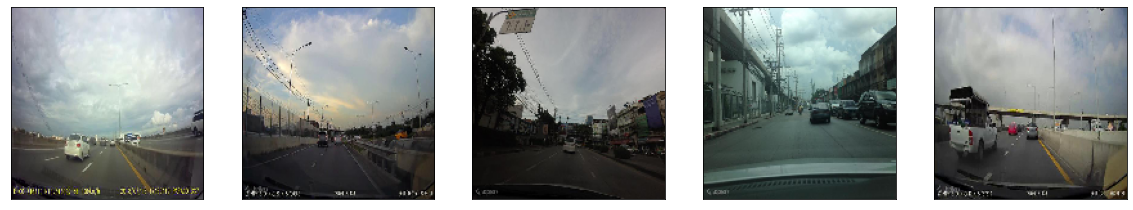

In [ ]:
  plt.figure(figsize=(20, 5))
  counter = 1
  for i in n_outlier_idx:
      ax = plt.subplot(1, n, counter)
      plt.imshow(X_test_bangkok[i,:,:,:])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      counter+=1
  plt.show()

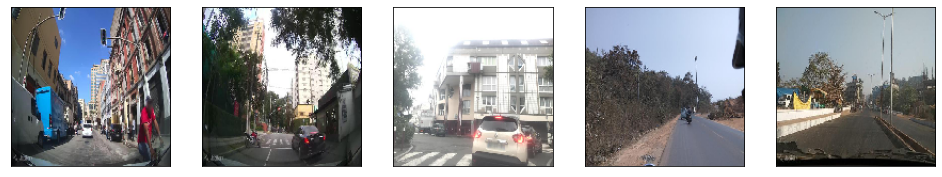

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Showing the 4 dimentions of 0-3 :


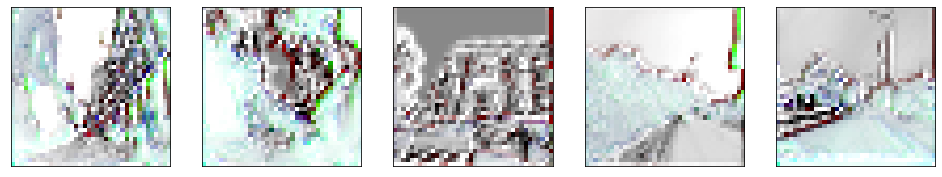

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Showing the 4 dimentions of 4-7 :


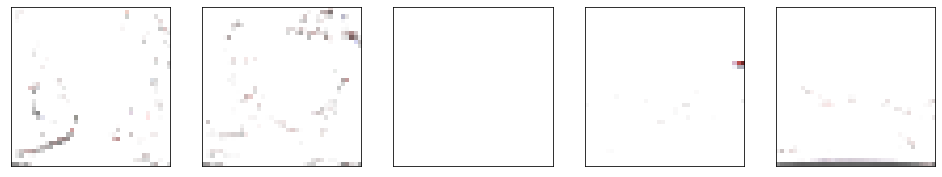

In [ ]:
show_original_and_encoded(X_train,encoded_imgs, n=5)

In [ ]:
# prepare test and train datasets

def train_test_split_cities(dataset,test_size=0.2):
  'Receives a numpy dataset of images, splits into train and test (no target!)'
  test_len = int(np.floor(len(dataset)*test_size))
  test_index = np.random.choice(len(dataset),test_len)
  train_index = list(set(list(range(len(dataset)))) - set(test_index))
  assert len(set(test_index) & set(train_index)) == 0  # check the two differ
  return dataset[train_index], dataset[test_index]


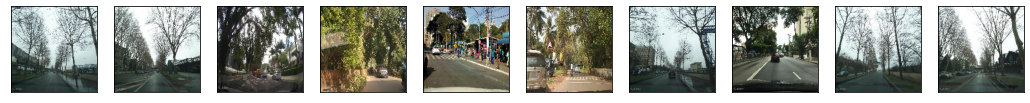

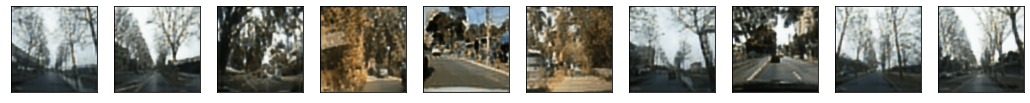

In [ ]:
show_original_and_decoded(X_train[outliers_idx], decoded_imgs[outliers_idx], n=5)

In [ ]:
from keras.callbacks import TensorBoard

# Setup Tensorboard - change from INACTIVE to Scalars after fit is done with the first epoch
# It will update throughout the training
!kill 1693
!rm -rf ./logs
logdir = "./logs"
%reload_ext tensorboard
tensorboard_callback = TensorBoard(log_dir=logdir,histogram_freq=1)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
%tensorboard --logdir "{logdir}"

In [ ]:
from keras.callbacks.callbacks import ModelCheckpoint

# set callback:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)

checkpoint_filepath = path_model + '/weights/Auto-Encoders.ckpt'
model_cp_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)
checkpoint_filepath

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val, X_val),
                callbacks=[tensorboard_callback,es_callback,model_cp_cb])

Train on 16966 samples, validate on 6516 samples
Epoch 1/100
16966/16966 [==============================] - 15s 907us/step - loss: 0.4966 - val_loss: 0.4968
Epoch 2/100
16966/16966 [==============================] - 15s 904us/step - loss: 0.4963 - val_loss: 0.4970
Epoch 3/100
16966/16966 [==============================] - 15s 903us/step - loss: 0.4961 - val_loss: 0.4978
Epoch 4/100
16966/16966 [==============================] - 15s 905us/step - loss: 0.4958 - val_loss: 0.4971
Epoch 5/100
16966/16966 [==============================] - 15s 903us/step - loss: 0.4955 - val_loss: 0.4945
Epoch 6/100
16966/16966 [==============================] - 15s 903us/step - loss: 0.4953 - val_loss: 0.4947
Epoch 7/100
16966/16966 [==============================] - 15s 904us/step - loss: 0.4951 - val_loss: 0.4981
Epoch 8/100
16966/16966 [==============================] - 15s 905us/step - loss: 0.4951 - val_loss: 0.4957
Epoch 9/100
16966/16966 [==============================] - 15s 903us/step - loss: 0.494

In [ ]:
decoded_imgs = autoencoder.predict(X_train)

## Idea of anomaly detection with autoencoders:
The learned compression scheme will be optimized for the
type of data contained in “normal” data points, so it will
probably lead to information loss on outliers.

## Application to image denoising
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:



In [ ]:
def autoencoder_shallow_model():
  """Receives a dataset, returns a decoded dataset using the pre-trained 
  pretty-shallow auto-enocder weights"""
  # Create the network
  input_img = Input(shape=(150, 150, 3))  # adapt this if using `channels_first` image data format
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((1, 1), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)
  # At this point the representation is (7, 7, 32)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

  return autoencoder, encoded, decoded


def decode_images_using_existing_shallow_model_weights(dataset,weights_path = '/weights/Auto-Encoders-denoiser.ckpt'):
  """Receives a numpy dataset, returns a decoded (denoised) dataset using 
  the pre-trained auto-encoder weights"""
  autoencoder, encoded, decoded = autoencoder_shallow_model()
  checkpoint_filepath = path_model + weights_path
  autoencoder.load_weights(checkpoint_filepath)
  return autoencoder.predict(dataset)

def encode_images_using_existing_model_weights(dataset,weights_path = '/weights/Auto-Encoders-denoiser.ckpt'):
  """Receives a numpy dataset, returns an encoded dataset (most relavent pixels)
  using the pre-trained auto-encoder weights"""
  autoencoder, encoded, decoded = autoencoder_shallow_model()
  checkpoint_filepath = path_model + weights_path
  autoencoder.load_weights(checkpoint_filepath)
  encoded_model = Model(input_img, encoded)
  return encoded_model.predict(dataset)


decoded_imgs_shallow = decode_images_using_existing_shallow_model_weights(X_train_bangkok)
encoded_imgs_shallow = encode_images_using_existing_shallow_model_weights(X_train_bangkok)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 150, 150, 32)      0  

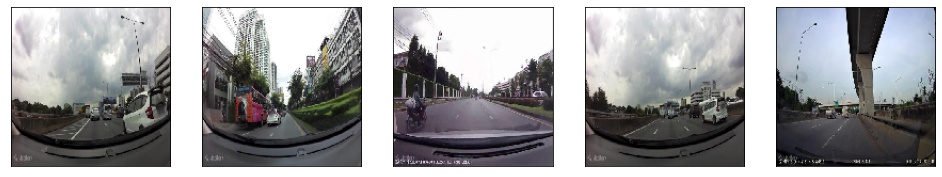

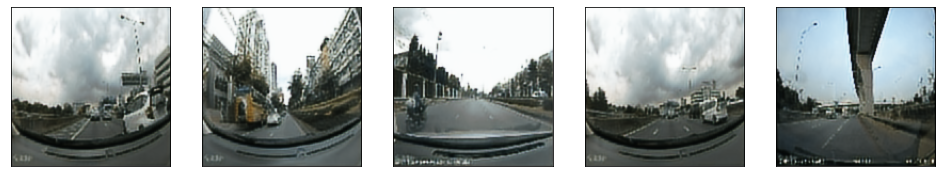

In [ ]:
show_original_and_decoded(X_train_bangkok, decoded_imgs_shallow, n=5)

In [ ]:
X_train_clean, outliers_idx = clean_dataset_from_outlier(X_train_city, decoded_imgs, outlier_threshold=0.98) 
show_original_and_decoded(X_train[outliers_idx], decoded_imgs[outliers_idx], n=10)

In [ ]:
from keras.callbacks import TensorBoard

# Setup Tensorboard - change from INACTIVE to Scalars after fit is done with the first epoch
# It will update thrhought the training
!kill 1693
!rm -rf ./logs
logdir = "./logs"
%reload_ext tensorboard
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)
%tensorboard --logdir "{logdir}"

/bin/bash: line 0: kill: (1693) - No such process


<IPython.core.display.Javascript object>

In [ ]:
from keras.callbacks.callbacks import ModelCheckpoint

input_img = Input(shape=(150, 150, 3))  # adapt this if using `channels_first` image data format
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((1, 1), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# At this point the representation is (7, 7, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

# set callback:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)

checkpoint_filepath = path_model + '/weights/Auto-Encoders-denoiser.ckpt'
model_cp_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)
checkpoint_filepath


autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val, X_val),
                callbacks=[tensorboard_callback,es_callback,model_cp_cb])


In [ ]:
decoded_imgs = autoencoder.predict(X_train)

In [ ]:
show_original_and_decoded(X_train,decoded_imgs, n=5)

## Finding outlier images
Now, we feed the data again as a whole to the autoencoder and check the error term on each sample. Finally, we get the error term for each data point by calculating the “distance” between the input data point (or the actual data point) and the output that was reconstructed by the autoencoder:


# Classify Cities

## Set image and batch size

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 512

In [ ]:
train_dir = Path("./train")
val_dir = Path("./val")
test_dir = Path("./test")

In [ ]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*_decoded')])
CLASS_NAMES

array(['ottawa_cleaned_decoded', 'tokyo_cleaned_decoded',
       'moscow_cleaned_decoded', 'cph_cleaned_decoded',
       'manila_cleaned_decoded', 'phoenix_cleaned_decoded',
       'boston_cleaned_decoded', 'budapest_cleaned_decoded',
       'helsinki_cleaned_decoded', 'goa_cleaned_decoded',
       'amsterdam_cleaned_decoded', 'melbourne_cleaned_decoded',
       'toronto_cleaned_decoded', 'paris_cleaned_decoded',
       'sf_cleaned_decoded', 'austin_cleaned_decoded',
       'berlin_cleaned_decoded', 'bangkok_cleaned_decoded',
       'saopaulo_cleaned_decoded'], dtype='<U25')

In [ ]:
train_image_count = len(list(train_dir.glob(f'REGULAR_CLASSES/*.jpg')))
val_image_count = len(list(val_dir.glob('*_decoded/*.jpg')))
test_image_count = len(list(test_dir.glob('*_decoded/*.jpg')))
train_image_count,val_image_count,test_image_count

(0, 35359, 35367)

## Cached processing \ tf.data.Dataset

In [ ]:
## Take all data
# TRAIN_SAMPLES = train_image_count
# VAL_SAMPLES = val_image_count

## Take subset of data
FACTOR = 10
TRAIN_SAMPLES = train_image_count//FACTOR
VAL_SAMPLES = val_image_count//FACTOR
list_train = tf.data.Dataset.list_files(str(train_dir/"*_cleaned/*")).take(TRAIN_SAMPLES)
list_val = tf.data.Dataset.list_files(str(val_dir/"*_cleaned/*")).take(VAL_SAMPLES)

In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
def augment(image,label):
  # image,label = convert(image, label)
  # image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  # image = tf.image.resize_with_crop_or_pad(image, int(IMG_WIDTH*1.2), int(IMG_HEIGHT*1.2)) # Add 6 pixels of padding
  # image = tf.image.random_crop(image, size=[BATCH_SIZE,IMG_WIDTH, IMG_HEIGHT, 3]) # Random crop back to 28x28
  # image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.rot90(image,tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

  return image,label

In [ ]:
def prepare_for_training(ds, aug=False, cache=False, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE,)

  if aug:
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
# Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train = list_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_val = list_val.map(process_path, num_parallel_calls=AUTOTUNE)


train_dataset = prepare_for_training(labeled_train,aug=False,cache=True)
val_dataset = prepare_for_training(labeled_val,cache='d')


# Build, Compile & Train

## Load class LeNet

In [ ]:
# Load class LeNet:
class LeNet:
    @staticmethod
    def build(numChannels, imgRows, imgCols, numClasses,
        activation="relu", weightsPath=None):
        # Initialize the model
        model = Sequential()
        inputShape = (imgRows, imgCols, numChannels)
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (numChannels, imgRows, imgCols)

        # Define the first set of CONV => ACTIVATION => POOL layers
        model.add(Conv2D(20, 5, padding="same",
        input_shape=inputShape))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))      

        # Define the second set of CONV => ACTIVATION => POOL layers
        model.add(Conv2D(15, 5, padding="same"))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # Define the first FC => ACTIVATION layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation(activation))
        
        # Define the second FC layer
        model.add(Dense(numClasses))
        # lastly, define the soft-max classifier
        model.add(Activation("softmax"))
        
        # If a weights path is supplied (inicating that the model was
        # pre-trained), then load the weights
        if weightsPath is not None:
            model.load_weights(weightsPath)
        # Return the constructed network architecture
        return model

## Initialize the Optimizer and the Model

In [ ]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
CLEANED_CLASS_NAMES = np.array([item.name for item in train_dir.glob('*clean*')])
DECODED_CLASS_NAMES = np.array([item.name for item in train_dir.glob('*decoded*')])
REGULAR_CLASSES = set(CLASS_NAMES) - set(DECODED_CLASS_NAMES) - set(CLEANED_CLASS_NAMES)
CLEANED_ONLY_CLASSES = np.array([item.name for item in train_dir.glob('*_cleaned/')])
REGULAR_CLASSES

{'amsterdam',
 'austin',
 'bangkok',
 'berlin',
 'boston',
 'budapest',
 'cph',
 'goa',
 'helsinki',
 'manila',
 'melbourne',
 'moscow',
 'ottawa',
 'paris',
 'phoenix',
 'saopaulo',
 'sf',
 'tokyo',
 'toronto'}

In [ ]:
# Build model:
model = LeNet().build(numChannels=3, 
                      imgRows=IMG_HEIGHT, 
                      imgCols=IMG_WIDTH, 
                      numClasses=len(DECODED_CLASS_NAMES))


# Compile model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("[INFO] compiling DONE")
model.summary()

## Setup Model Prerequisites

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
path_model = '/content/gdrive/My Drive/adidas/02-model'
path_data =  '/content/gdrive/My Drive/adidas/01-data'
os.listdir(path_model) # test

In [ ]:
# Set checkpoint:
checkpoint_filepath = path_model + '/weights/19Cities-CNN-03.ckpt'
model_cp_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    save_best_only=True)
checkpoint_filepath

In [ ]:
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
VAL_STEPS = np.ceil(val_image_count/BATCH_SIZE)

# Train 🚂

In [ ]:
# model.load_weights(checkpoint_filepath)
# model.save('./model.h5')
model = tf.keras.models.load_model(str(path_model) + '/MobileNet-19cities-ACC90.h5')

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,verbose=1,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(patience=4,verbose=1)

logdir = "./logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)


history = model.fit(train_dataset, steps_per_epoch=STEPS_PER_EPOCH,
          epochs=40, 
          verbose=1, 
          validation_data=val_dataset,validation_steps=VAL_STEPS,
          callbacks=[model_cp_cb,tensorboard_callback,es_callback,reduce_lr])
          # callbacks=[tensorboard_callback,es_callback,reduce_lr])

In [ ]:
city_dict = {}
for i, j in enumerate(CLASS_NAMES):
  city_dict[i] = j.title()
city_dict

import tensorflow as tf
import PIL

def predict(image):
    # Pre-process
    x = tf.keras.preprocessing.image.load_img(image, target_size=(IMG_WIDTH, IMG_HEIGHT))
    x = tf.keras.preprocessing.image.img_to_array(x)/255
    x = np.expand_dims(x, axis=0)
    array = model.predict(x)
    result = array[0]
    answer = np.argmax(result)


    return f"Computer says our image is probably from: {city_dict[answer]}"



In [ ]:
par = val_dir/'paris'
tok =  val_dir/'tokyo'
i = list(par.glob('*'))[367]
# print(predict(i))
for i in list(tok.glob('*'))[:100]:
  print(predict(i))

# Evaluate Model

In [ ]:
# Setup Tensorboard - change from INACTIVE to Scalars after fit is done with the first epoch
# It will update throughout the training

!rm -rf ./logs
%reload_ext tensorboard
%tensorboard --logdir "{logdir}"

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Get y_true and y_pred
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

def get_data_to_numpy(file_list):
    X = []
    for filename in file_list :
        img = img_to_array(load_img(filename, target_size = (IMG_WIDTH,IMG_HEIGHT)))
        X.append(img)
    X = np.array(X).astype('float32')
    # X = (X - X.mean()) / X.mean()
    X = X / 255

    return X


def get_label(file_list):
  y = []
  for filename in file_list:
    city_name = filename.split('/')[2]
    y.append(city_name == CLASS_NAMES)

  return np.array(y)


def make_test_dataset(n=5000):
  test_filelist = glob.glob('./test/*/*')
  np.random.shuffle(test_filelist)
  files = test_filelist[:n]
  labels = get_label(files)
  # Load the raw data from the file as a string
  images = get_data_to_numpy(files)
  
  return images, labels

In [ ]:
X_true,Y_true = make_test_dataset(5000)
y_true = np.argmax(Y_true, axis=1)
Y_pred = model.predict(np.array(X_true), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt='g',cmap = 'coolwarm', square=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual');

# Lime Interpretations

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_sure(Y_pred, y_true, num_city=10, con_level=0.95, correct=True):
  indices = []
  for i, pred in enumerate(Y_pred):
    if correct:
      if y_true[i] == np.argmax(pred) and pred.max() > con_level:
        indices.append(i)
    else:
      if y_true[i] != np.argmax(pred) and pred.max() > con_level:
        indices.append(i)
  return np.random.choice(np.array(indices), size=num_city)

def plot_super_pixels(indices):
  explainer = lime_image.LimeImageExplainer()
  fig, axs = plt.subplots(len(indices), 2, figsize=(15, 15))
  for i, ind in enumerate(indices):
    explanation = explainer.explain_instance(X_true[ind], model.predict, top_labels=3, hide_color=None, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=True)

    axs[i, 0].imshow((mark_boundaries(temp / 2 + 0.5, mask)* 255).astype(np.uint8))
    axs[i, 0].set_title("the model predicted: " + city_dict[y_pred[ind]] + " the actual is: " + city_dict[y_true[ind]])
    axs[i, 1].imshow(X_true[ind])
    axs[i, 1].set_title("original image")


In [ ]:
CLASS_NAMES
city_dict = {}
for i,j in enumerate(CLASS_NAMES):
  city_dict[i] = j.title()
city_dict

{0: 'Goa',
 1: 'Boston',
 2: 'Berlin',
 3: 'Helsinki',
 4: 'Phoenix',
 5: 'Toronto',
 6: 'Saopaulo',
 7: 'Austin',
 8: 'Paris',
 9: 'Moscow',
 10: 'Sf',
 11: 'Cph',
 12: 'Amsterdam',
 13: 'Budapest',
 14: 'Bangkok',
 15: 'Tokyo',
 16: 'Manila',
 17: 'Ottawa',
 18: 'Melbourne'}

In [ ]:
my_certain = get_sure(Y_pred, y_true,3, correct=True)
plot_super_pixels(my_certain)


# Generalization

In [ ]:
# Setup generalization dataset (from drive)
gen_dir = Path(path_data+'/generalization/')
list_gen = tf.data.Dataset.list_files(str(gen_dir/"*/*"),shuffle=False)
labeled_gen = list_gen.map(process_path, num_parallel_calls=AUTOTUNE)
gen_dataset = prepare_for_training(labeled_gen)

# Get y_true and y_pred
X_true = np.array([l[0].numpy() for l in list(labeled_gen)])
Y_true = np.array([list(l[1].numpy()) for l in list(labeled_gen)])
y_true = np.argmax(Y_true,axis=1)
Y_pred = model.predict(np.array(X_true),verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt='g',cmap = 'coolwarm', square=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual');